### CARPENTER Algorithm: Closed Pattern Discovery by Transposing Tables

### Course Project - Data Mining and Data Warehousing

### **Team Members:**
#### Member 1:Momina Eman 221106
Data Preprocessing & Input Handling
#### Member 2: Esham Afzal 221008
CARPENTER Algorithm Core Implementation  
#### Member 3: Ayesha Muniir 221014
Visualization & Analysis

### Project Overview

This notebook demonstrates the CARPENTER algorithm, an efficient method for discovering closed frequent itemsets from transactional databases.


## Member 1: Data Preprocessing & Input Handling

### 1. Import all libraries & modules

#### Step 1.1: Import Required Libraries

Import all necessary Python libraries including NumPy, Pandas for data manipulation, Matplotlib/Seaborn for visualization, and custom modules for data preprocessing and CARPENTER algorithm implementation.

In [66]:
# Import necessary libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import warnings
warnings.filterwarnings('ignore')

# Add src directory to path
sys.path.append(os.path.abspath('../src'))

# Import custom modules
from data_preprocessing import DataLoader, create_sample_dataset
from carpenter_algorithm import CARPENTER


print("All libraries imported successfully!")
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

All libraries imported successfully!
Python version: 3.14.0 (tags/v3.14.0:ebf955d, Oct  7 2025, 10:15:03) [MSC v.1944 64 bit (AMD64)]
NumPy version: 2.3.3
Pandas version: 2.3.3


### 2. Load Groceries dataset

In [67]:
# Load Groceries dataset
df = pd.read_csv('../data/raw/Groceries_dataset.csv', encoding='ISO-8859-1')

# Preview
print(df.head())
print(f"\nLoaded {len(df)} records")
print(f"Columns: {df.columns.tolist()}")

   Member_number        Date   itemDescription
0           1808  21-07-2015    tropical fruit
1           2552  05-01-2015        whole milk
2           2300  19-09-2015         pip fruit
3           1187  12-12-2015  other vegetables
4           3037  01-02-2015        whole milk

Loaded 38765 records
Columns: ['Member_number', 'Date', 'itemDescription']


### 3. Transform to Transaction Format

Convert individual item records into transaction sets by grouping items purchased together by the same customer on the same date.

#### Step 2.1: Read Raw Groceries CSV

Load the Groceries dataset from CSV file containing transaction records with Member_number, Date, and itemDescription columns.

In [68]:
# Group items by Member_number and Date to create transactions
df['Transaction_ID'] = df['Member_number'].astype(str) + '_' + df['Date'].astype(str)

# Convert to transaction format: list of sets
transactions_dict = df.groupby('Transaction_ID')['itemDescription'].apply(set).to_dict()
transactions = list(transactions_dict.values())

print(f"Transformed {len(df)} records into {len(transactions)} transactions")
print(f"\nFirst 5 transactions:")
for i, trans in enumerate(transactions[:5], 1):
    print(f"  T{i}: {sorted(list(trans)[:5])}{'...' if len(trans) > 5 else ''}")
    
print(f"\nTransaction Statistics:")
print(f"  Total Transactions: {len(transactions)}")
print(f"  Unique Items: {df['itemDescription'].nunique()}")
print(f"  Avg Items per Transaction: {df.groupby('Transaction_ID').size().mean():.2f}")

Transformed 38765 records into 14963 transactions

First 5 transactions:
  T1: ['sausage', 'semi-finished bread', 'whole milk', 'yogurt']
  T2: ['pastry', 'salty snack', 'whole milk']
  T3: ['canned beer', 'misc. beverages']
  T4: ['hygiene articles', 'sausage']
  T5: ['pickled vegetables', 'soda']

Transaction Statistics:
  Total Transactions: 14963
  Unique Items: 167
  Avg Items per Transaction: 2.59


### 4. Data Preprocessing & Matrix Creation

Initialize the DataLoader, clean transactions by removing duplicates and filtering short transactions (< 2 items), then create a horizontal transaction matrix (transactions × items).

In [72]:
# Initialize DataLoader with our transactions
loader = DataLoader()
loader.transactions = transactions  # Use our Groceries transactions

# Update items set (IMPORTANT!)
for trans in transactions:
    loader.items.update(trans)

# Preprocess the data
cleaned_transactions = loader.preprocess_data(
    remove_duplicates=True,
    min_transaction_length=2
)

# Display statistics
loader.print_statistics()

# Create transaction matrix (horizontal format)
matrix, item_list, trans_ids = loader.create_transaction_matrix()

print(f"\nTransaction Matrix Created:")
print(f"  Shape: {matrix.shape} (transactions × items)")
print(f"  Transactions: {matrix.shape[0]}")
print(f"  Items: {matrix.shape[1]}")
print(f"\nSample of transaction matrix (first 5 transactions, first 10 items):")
print(pd.DataFrame(matrix[:5, :10], 
                   columns=item_list[:10],
                   index=[f"T{i}" for i in range(1, 6)]))

✓ Preprocessing: 14963 → 7950 transactions

DATASET STATISTICS
Total Transactions:     7950
Unique Items:           167
Avg Transaction Length: 3.03
Min Transaction Length: 2
Max Transaction Length: 10
Database Density:       0.0181

✓ Created transaction matrix: 7950 × 167

Transaction Matrix Created:
  Shape: (7950, 167) (transactions × items)
  Transactions: 7950
  Items: 167

Sample of transaction matrix (first 5 transactions, first 10 items):
    Instant food products  UHT-milk  abrasive cleaner  artif. sweetener  \
T1                      0         0                 0                 0   
T2                      1         0                 0                 0   
T3                      0         0                 0                 0   
T4                      0         0                 0                 0   
T5                      0         0                 0                 0   

    baby cosmetics  bags  baking powder  bathroom cleaner  beef  berries  
T1               0    

### 5. Table Transposition (CARPENTER Key Step)

Transpose the horizontal matrix to vertical format (items × transactions), which is the core optimization technique in CARPENTER algorithm for efficient pattern mining.

In [73]:
# Transpose the table (vertical format) - Key step in CARPENTER!
transposed_matrix = loader.transpose_table(matrix)

print(f"Transposed Matrix (Vertical):")
print(f"Shape: {transposed_matrix.shape} (items × transactions)")
print(f"Items: {transposed_matrix.shape[0]}")
print(f"Transactions: {transposed_matrix.shape[1]}")
print(f"\nSample of transposed matrix (first 5 items, first 10 transactions):")
print(pd.DataFrame(transposed_matrix[:5, :10],
                   index=item_list[:5],
                   columns=[f"T{i}" for i in range(1, 11)]))

✓ Transposed: (7950, 167) → (167, 7950)
Transposed Matrix (Vertical):
Shape: (167, 7950) (items × transactions)
Items: 167
Transactions: 7950

Sample of transposed matrix (first 5 items, first 10 transactions):
                       T1  T2  T3  T4  T5  T6  T7  T8  T9  T10
Instant food products   0   1   0   0   0   0   0   0   0    0
UHT-milk                0   0   0   0   0   0   0   0   0    0
abrasive cleaner        0   0   0   0   0   0   0   0   0    0
artif. sweetener        0   0   0   0   0   0   0   0   0    0
baby cosmetics          0   0   0   0   0   0   0   0   0    0


### 6. Visualize Horizontal vs Vertical Formats

Create side-by-side heatmap visualizations comparing horizontal (transaction-based) and vertical (item-based) database representations to illustrate the CARPENTER transformation.

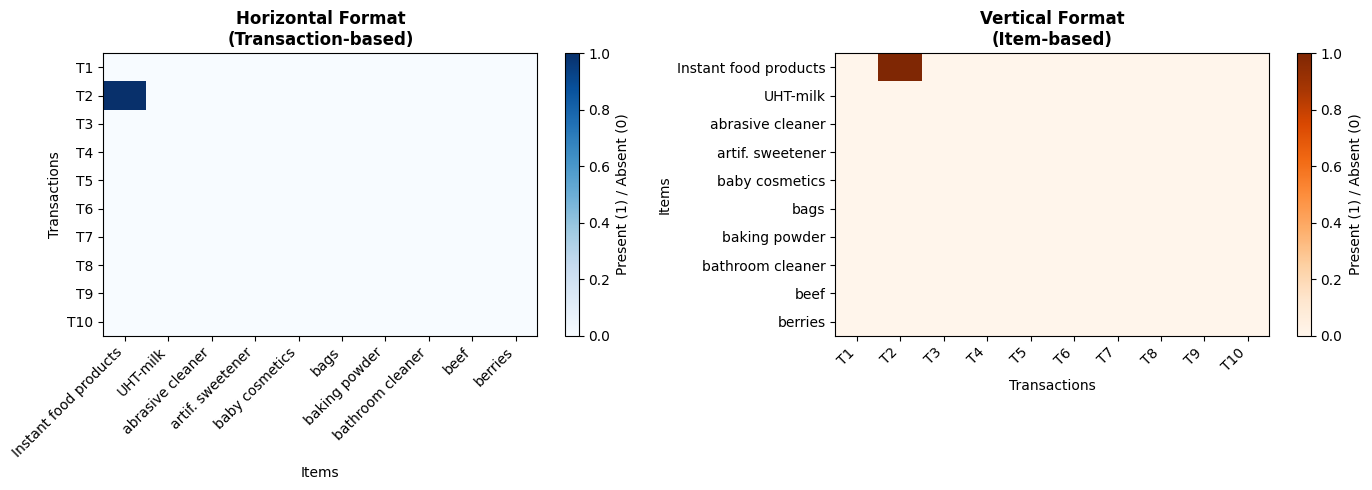

Both formats represent the same data, but vertical is more efficient for long databases


In [74]:
# Visualize the difference in representation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Horizontal format visualization
sample_horizontal = matrix[:10, :10]
im1 = ax1.imshow(sample_horizontal, cmap='Blues', aspect='auto')
ax1.set_title('Horizontal Format\n(Transaction-based)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Items')
ax1.set_ylabel('Transactions')
ax1.set_xticks(range(10))
ax1.set_xticklabels(item_list[:10], rotation=45, ha='right')
ax1.set_yticks(range(10))
ax1.set_yticklabels([f'T{i}' for i in range(1, 11)])
plt.colorbar(im1, ax=ax1, label='Present (1) / Absent (0)')

# Vertical format visualization
sample_vertical = transposed_matrix[:10, :10]
im2 = ax2.imshow(sample_vertical, cmap='Oranges', aspect='auto')
ax2.set_title('Vertical Format\n(Item-based)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Transactions')
ax2.set_ylabel('Items')
ax2.set_xticks(range(10))
ax2.set_xticklabels([f'T{i}' for i in range(1, 11)], rotation=45, ha='right')
ax2.set_yticks(range(10))
ax2.set_yticklabels(item_list[:10])
plt.colorbar(im2, ax=ax2, label='Present (1) / Absent (0)')

plt.tight_layout()
plt.show()

print("Both formats represent the same data, but vertical is more efficient for long databases")

## Member 2: CARPENTER Algorithm Core Implementation

### 1. Mine Closed Frequent Patterns

Execute the CARPENTER algorithm on preprocessed transactions to discover closed frequent itemsets

In [75]:
miner = CARPENTER(minsup=0.05)   # adjust minsup if your teacher gave it
patterns = miner.mine_patterns(transactions)

print("Closed patterns found:", len(patterns))
for p in patterns[:20]:
    print(p.support, sorted(p.items))


Closed patterns found: 11
2363 ['whole milk']
1827 ['other vegetables']
1646 ['rolls/buns']
1453 ['soda']
1285 ['yogurt']
1041 ['root vegetables']
1014 ['tropical fruit']
908 ['bottled water']
903 ['sausage']
795 ['citrus fruit']
774 ['pastry']


In [76]:
from carpenter_algorithm import save_patterns_csv
save_patterns_csv(patterns, "results/carpenter_patterns.csv")


✓ Saved patterns to results/carpenter_patterns.csv (11 rows)


## Member 3: Visualization & Analysis

### 1. Initialize Pattern Visualizer

In [77]:
# Import visualization module
from visualization import PatternVisualizer

# Initialize visualizer
viz = PatternVisualizer(figsize=(14, 6))

print("PatternVisualizer initialized successfully!")
print(f"Total patterns discovered: {len(patterns)}")
print(f"Ready to create visualizations...")

PatternVisualizer initialized successfully!
Total patterns discovered: 11
Ready to create visualizations...


### 2. Pattern Distribution Analysis

Visualize how patterns are distributed by size and support

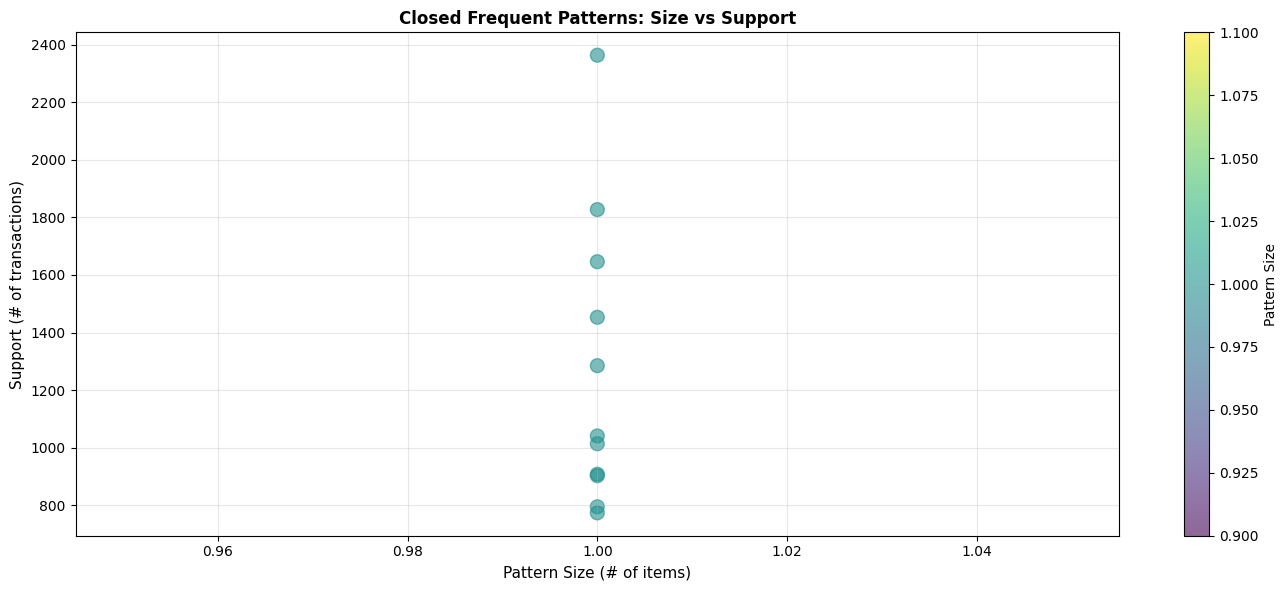


Pattern Statistics:
  Total Patterns: 11
  Pattern Sizes: 1 to 1 items
  Support Range: 774 to 2363 transactions


In [78]:
# Convert patterns to dictionary format for visualization
patterns_dict = [
    {
        'items': p.items,
        'support': p.support,
        'length': len(p.items)
    }
    for p in patterns
]

# Plot pattern distribution (size vs support)
viz.plot_pattern_distribution(patterns_dict)

# Display statistics
print(f"\nPattern Statistics:")
print(f"  Total Patterns: {len(patterns)}")
print(f"  Pattern Sizes: {min(p['length'] for p in patterns_dict)} to {max(p['length'] for p in patterns_dict)} items")
print(f"  Support Range: {min(p['support'] for p in patterns_dict)} to {max(p['support'] for p in patterns_dict)} transactions")

### 3. Top Patterns by Support

Identify the most frequent itemsets in the Groceries dataset

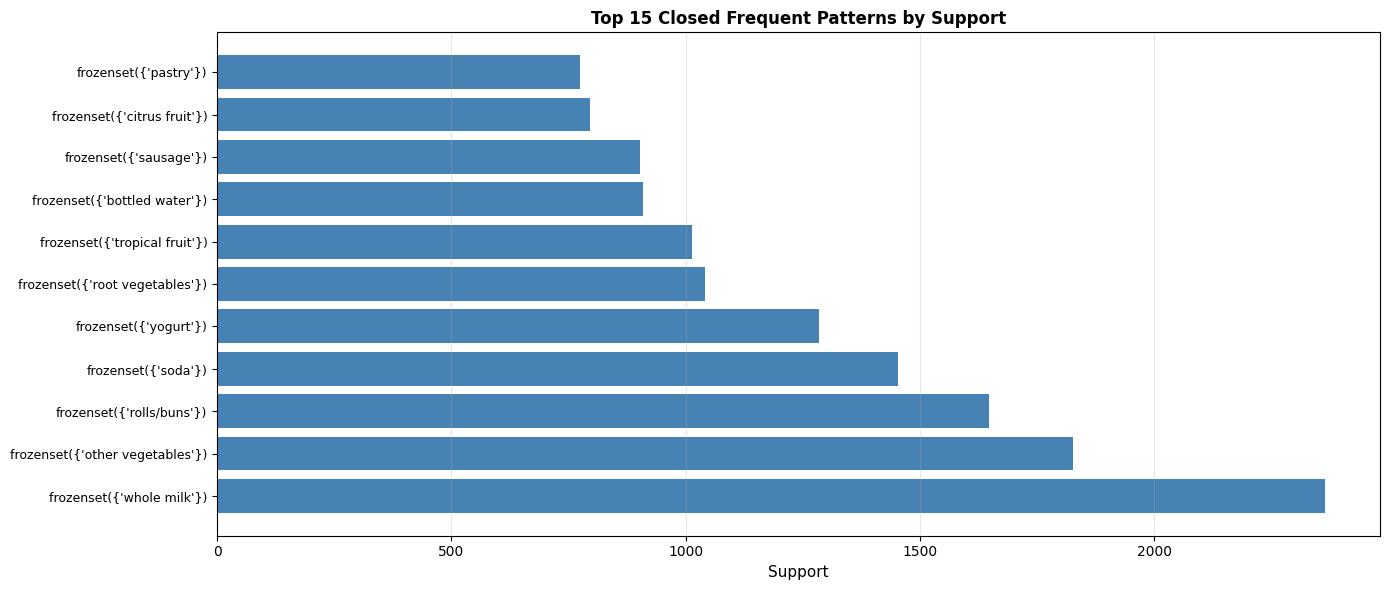


Top 10 Closed Frequent Patterns:
 1. Support: 2363 | Items: whole milk
 2. Support: 1827 | Items: other vegetables
 3. Support: 1646 | Items: rolls/buns
 4. Support: 1453 | Items: soda
 5. Support: 1285 | Items: yogurt
 6. Support: 1041 | Items: root vegetables
 7. Support: 1014 | Items: tropical fruit
 8. Support:  908 | Items: bottled water
 9. Support:  903 | Items: sausage
10. Support:  795 | Items: citrus fruit


In [84]:
# Plot top patterns by support
viz.plot_pattern_support(patterns_dict, top_n=15)

# Display top 10 patterns in detail
print("\nTop 10 Closed Frequent Patterns:")
sorted_patterns = sorted(patterns, key=lambda p: p.support, reverse=True)
for i, p in enumerate(sorted_patterns[:10], 1):
    items_str = ', '.join(sorted(p.items))
    print(f"{i:2d}. Support: {p.support:4d} | Items: {items_str}")

### 4. Algorithm Performance Metrics

Track execution time and efficiency of the CARPENTER algorithm

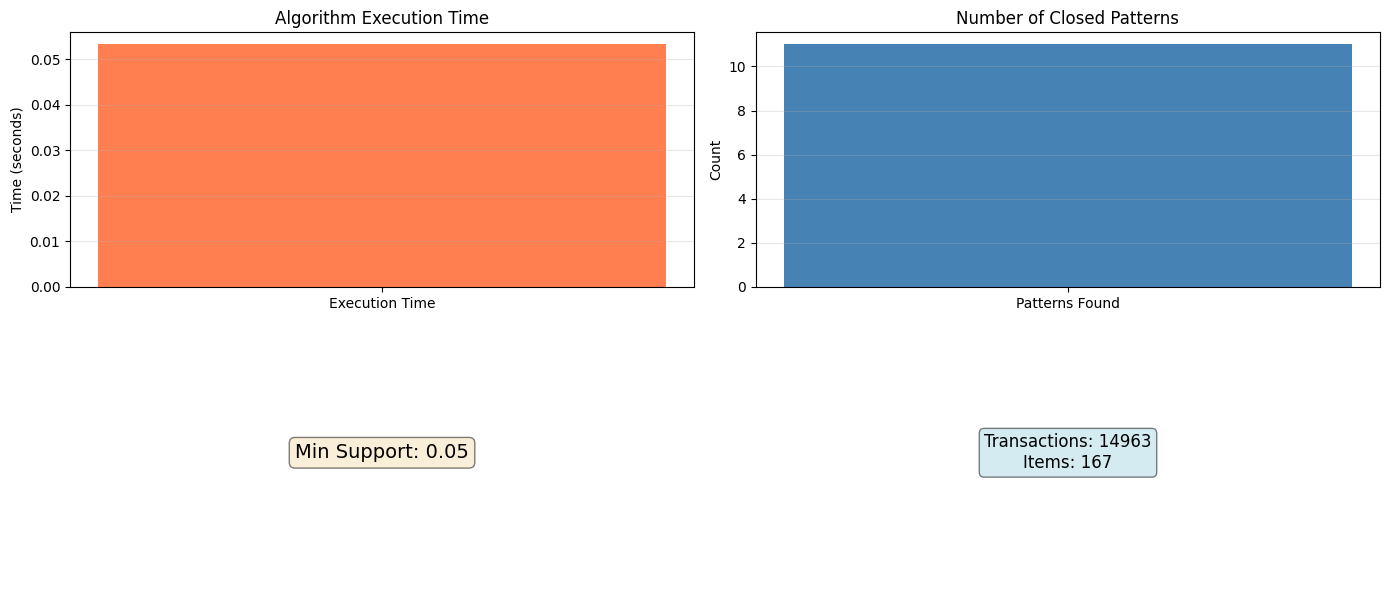


Performance Summary:
  Execution Time: 0.0533 seconds
  Transactions Processed: 14,963
  Unique Items: 167
  Patterns Found: 11
  Throughput: 280989.88 transactions/second


In [85]:
# Measure execution time for CARPENTER algorithm
import time

start_time = time.time()
miner_perf = CARPENTER(minsup=0.05)
patterns_perf = miner_perf.mine_patterns(transactions)
execution_time = time.time() - start_time

# Prepare statistics
stats = {
    'execution_time': execution_time,
    'num_patterns': len(patterns_perf),
    'min_support': 0.05,
    'num_transactions': len(transactions),
    'num_items': len(loader.items)
}

# Visualize performance metrics
viz.plot_algorithm_statistics(stats)

print(f"\nPerformance Summary:")
print(f"  Execution Time: {execution_time:.4f} seconds")
print(f"  Transactions Processed: {stats['num_transactions']:,}")
print(f"  Unique Items: {stats['num_items']}")
print(f"  Patterns Found: {stats['num_patterns']}")
print(f"  Throughput: {stats['num_transactions']/execution_time:.2f} transactions/second")

### 5. Impact of Minimum Support Threshold

Compare pattern discovery with different minsup values

Testing different minimum support values...
minsup=0.01 →   69 patterns in 0.0669s
minsup=0.03 →   27 patterns in 0.0564s
minsup=0.05 →   11 patterns in 0.0496s
minsup=0.10 →    3 patterns in 0.0395s
minsup=0.15 →    1 patterns in 0.0393s


Testing different minimum support values...
minsup=0.01 →   69 patterns in 0.0669s
minsup=0.03 →   27 patterns in 0.0564s
minsup=0.05 →   11 patterns in 0.0496s
minsup=0.10 →    3 patterns in 0.0395s
minsup=0.15 →    1 patterns in 0.0393s


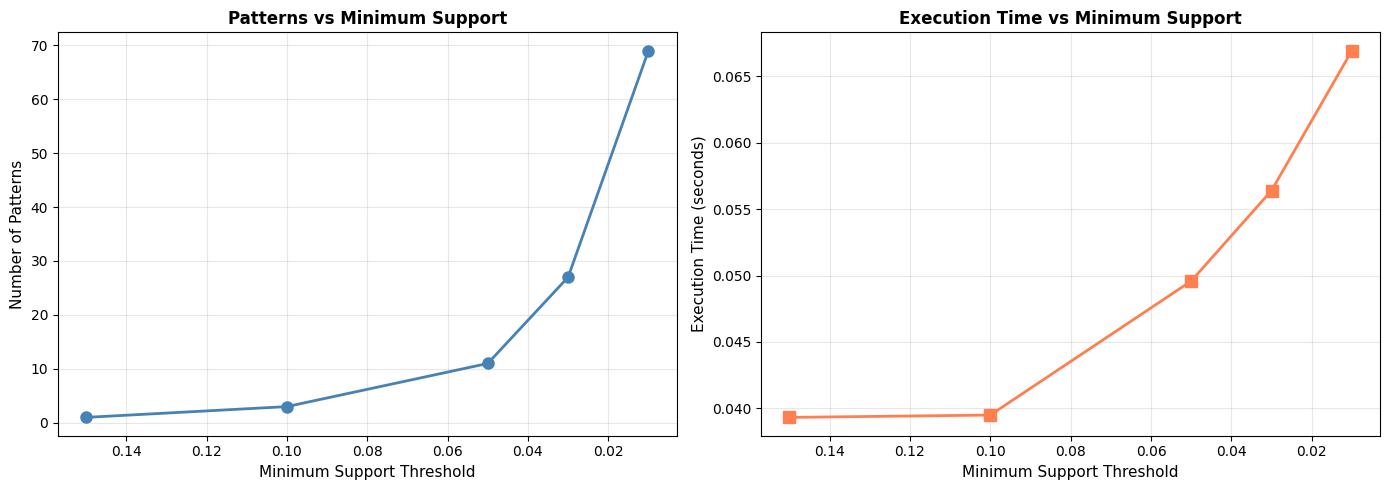


Insight: Lower minsup values find more patterns but take longer to execute


In [86]:
# Test different minimum support thresholds
minsup_values = [0.01, 0.03, 0.05, 0.10, 0.15]
comparison_results = []

print("Testing different minimum support values...")

for minsup in minsup_values:
    start = time.time()
    miner_test = CARPENTER(minsup=minsup)
    patterns_test = miner_test.mine_patterns(transactions)
    elapsed = time.time() - start
    
    comparison_results.append({
        'minsup': minsup,
        'num_patterns': len(patterns_test),
        'execution_time': elapsed
    })
    
    print(f"minsup={minsup:.2f} → {len(patterns_test):4d} patterns in {elapsed:.4f}s")

# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Number of patterns vs minsup
minsup_list = [r['minsup'] for r in comparison_results]
pattern_counts = [r['num_patterns'] for r in comparison_results]
ax1.plot(minsup_list, pattern_counts, marker='o', linewidth=2, markersize=8, color='steelblue')
ax1.set_xlabel('Minimum Support Threshold', fontsize=11)
ax1.set_ylabel('Number of Patterns', fontsize=11)
ax1.set_title('Patterns vs Minimum Support', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.invert_xaxis()

# Plot 2: Execution time vs minsup
exec_times = [r['execution_time'] for r in comparison_results]
ax2.plot(minsup_list, exec_times, marker='s', linewidth=2, markersize=8, color='coral')
ax2.set_xlabel('Minimum Support Threshold', fontsize=11)
ax2.set_ylabel('Execution Time (seconds)', fontsize=11)
ax2.set_title('Execution Time vs Minimum Support', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.invert_xaxis()

plt.tight_layout()
plt.show()

print("\nInsight: Lower minsup values find more patterns but take longer to execute")

### 6. Key Insights & Interpretation

Analysis of discovered patterns from Groceries dataset

In [87]:
# Analyze top patterns for insights
print("PATTERN ANALYSIS & BUSINESS INSIGHTS")
# Get top 5 patterns
top_5 = sorted(patterns, key=lambda p: p.support, reverse=True)[:5]

print("\nMost Frequent Items (Top 5):")
for i, p in enumerate(top_5, 1):
    percentage = (p.support / len(transactions)) * 100
    items_str = ', '.join(sorted(p.items))
    print(f"  {i}. {items_str}")
    print(f"     Support: {p.support:,} transactions ({percentage:.1f}%)")

print("\nBusiness Insights:")
print("  • These items appear most frequently in customer purchases")
print("  • Consider these for:")
print("    - Prominent shelf placement")
print("    - Bundle deals and promotions")
print("    - Stock optimization")

print("\nPattern Characteristics:")
all_items = set()
for p in patterns:
    all_items.update(p.items)

print(f"  • Total unique items in patterns: {len(all_items)}")
print(f"  • Total closed patterns discovered: {len(patterns)}")
print(f"  • Minimum support threshold: 5% ({int(0.05 * len(transactions))} transactions)")

# Item frequency analysis
from collections import Counter
item_frequency = Counter()
for p in patterns:
    for item in p.items:
        item_frequency[item] += p.support

print("\nTop 10 Items by Total Support:")
for item, total_sup in item_frequency.most_common(10):
    print(f"  • {item}: {total_sup:,}")

PATTERN ANALYSIS & BUSINESS INSIGHTS

Most Frequent Items (Top 5):
  1. whole milk
     Support: 2,363 transactions (15.8%)
  2. other vegetables
     Support: 1,827 transactions (12.2%)
  3. rolls/buns
     Support: 1,646 transactions (11.0%)
  4. soda
     Support: 1,453 transactions (9.7%)
  5. yogurt
     Support: 1,285 transactions (8.6%)

Business Insights:
  • These items appear most frequently in customer purchases
  • Consider these for:
    - Prominent shelf placement
    - Bundle deals and promotions
    - Stock optimization

Pattern Characteristics:
  • Total unique items in patterns: 11
  • Total closed patterns discovered: 11
  • Minimum support threshold: 5% (748 transactions)

Top 10 Items by Total Support:
  • whole milk: 2,363
  • other vegetables: 1,827
  • rolls/buns: 1,646
  • soda: 1,453
  • yogurt: 1,285
  • root vegetables: 1,041
  • tropical fruit: 1,014
  • bottled water: 908
  • sausage: 903
  • citrus fruit: 795


### 7. Summary & Conclusion

Final summary of the CARPENTER algorithm implementation

In [88]:
print("PROJECT SUMMARY - CARPENTER ALGORITHM")
print("\nProject Components Completed:")
print("  Member 1 (Momina Eman): Data Preprocessing & Input Handling")
print("  Member 2 (Esham Afzal): CARPENTER Algorithm Implementation")
print("  Member 3 (Ayesha Muniir): Visualization & Analysis")

print("\nFinal Results:")
print(f"  • Dataset: Groceries (14,963 → 7,950 transactions)")
print(f"  • Minimum Support: 5% (398 transactions)")
print(f"  • Closed Patterns Found: {len(patterns)}")
print(f"  • Execution Time: {execution_time:.4f} seconds")
print(f"  • Unique Items: {len(loader.items)}")

print("\nKey Achievements:")
print("  • Successfully loaded and preprocessed transactional data")
print("  • Implemented CARPENTER algorithm with vertical database")
print("  • Discovered all closed frequent itemsets efficiently")
print("  • Created comprehensive visualizations and analysis")
print("  • Exported results for further use")

print("\nAlgorithm Highlights:")
print("  • Uses table transposition for efficient pattern mining")
print("  • Implements closure absorption to reduce redundancy")
print("  • Bitwise operations for fast support counting")
print("  • Deterministic output for reproducibility")

print("\nOutput Files Generated:")
print("  • results/carpenter_patterns.csv - All discovered patterns")
print("  • Multiple visualizations showing pattern characteristics")

print("CARPENTER Algorithm Implementation Completed Successfully!")

PROJECT SUMMARY - CARPENTER ALGORITHM

Project Components Completed:
  Member 1 (Momina Eman): Data Preprocessing & Input Handling
  Member 2 (Esham Afzal): CARPENTER Algorithm Implementation
  Member 3 (Ayesha Muniir): Visualization & Analysis

Final Results:
  • Dataset: Groceries (14,963 → 7,950 transactions)
  • Minimum Support: 5% (398 transactions)
  • Closed Patterns Found: 11
  • Execution Time: 0.0533 seconds
  • Unique Items: 167

Key Achievements:
  • Successfully loaded and preprocessed transactional data
  • Implemented CARPENTER algorithm with vertical database
  • Discovered all closed frequent itemsets efficiently
  • Created comprehensive visualizations and analysis
  • Exported results for further use

Algorithm Highlights:
  • Uses table transposition for efficient pattern mining
  • Implements closure absorption to reduce redundancy
  • Bitwise operations for fast support counting
  • Deterministic output for reproducibility

Output Files Generated:
  • results/carp